# Entrenamiento de modelos

## Importaciones

### Librerias básicas

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Tratamiento y visualización de datos

In [2]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import mean_squared_error as mse
from hyperopt import fmin, tpe, Trials, STATUS_OK

### Modelos

In [3]:
from lightgbm import LGBMClassifier

### Funciones auxiliares

In [4]:
from src.exploring_functions import *
from src.predicting_functions import *

Viendo la gran cantidad de celdas que comprenden los datos, se va a optar por usar un modelo GBM ligero. Lo primero que se tiene que decidir es el conjunto de datos que aporta mejores resultados, si es el conjunto inicial, o los datos reducidos por PCA  o los reducidos con UMAP.

### Datos

Datos: PCA


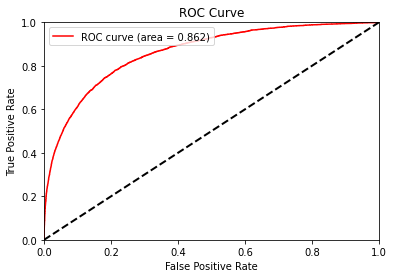

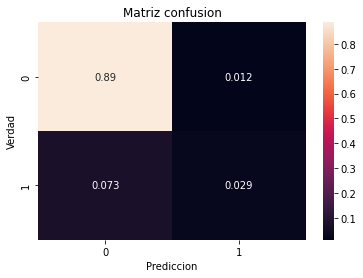

------------------
Datos: UMAP


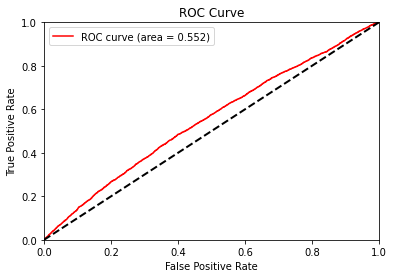

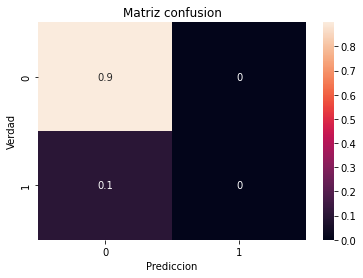

------------------
Datos: sin modificar


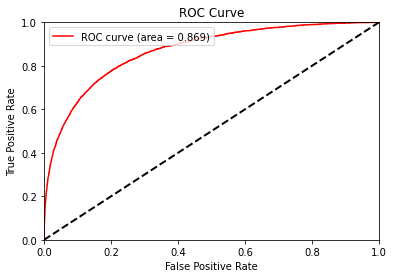

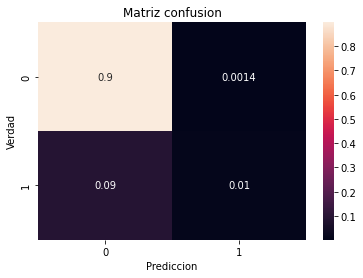

------------------


In [5]:
for e in ["_pca.csv", "_umap.csv", ".csv"]:
    # Importación de los datos
    train = pd.read_csv('./data/train' + e).drop(columns=["ID_code"], errors='ignore')
    test = pd.read_csv('./data/test' + e).drop(columns=["ID_code"], errors='ignore')

    # Separación en parte de train y test
    X_train, X_test, y_train, y_test = train_test(train)

    if e!='.csv':
        print("Datos:", e[1:-4].upper())
    else:
        print("Datos: sin modificar")

    # Entrenamiento del modelo
    fpr, tpr, roc_auc, y_pred = reg_model(LGBMClassifier(n_jobs=-1), X_train, X_test, y_train, y_test)

    # Plot de la curva roc y de la matriz de confusión
    roc_curve_plot(fpr, tpr, roc_auc)
    confusion_matrix_total(y_test, y_pred)
    print('------------------')


Se comprueba como los mejores resultados se consiguen con el conjunto de datos no modificados, siendo los reducidos con UMAP significativamente peores y los reducidos con PCA ligeramente peores. Por lo que se usarán solo los datos no modificados

Como se puede ver, el modelo está sesgado. Al haber una mayor proporción de filas con valor de target 0 que 1, el modelo tiene muchos falsos negativos. Para solucionar esto hay que balancear los datos.

## Balanceo de datos

In [6]:
train = pd.read_csv('./data/train.csv').drop(columns=["ID_code"], errors='ignore')
donwcast_df(train)
test = pd.read_csv('./data/test.csv').drop(columns=["ID_code"], errors='ignore')

Memory usage of properties dataframe is : 306.7017822265625  MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  152.77874755859375  MB
This is  49.81345281056605 % of the initial size


El porcentaje de 0 en el target es: 89.95 %
El porcentaje de 1 en el target es: 10.05 %


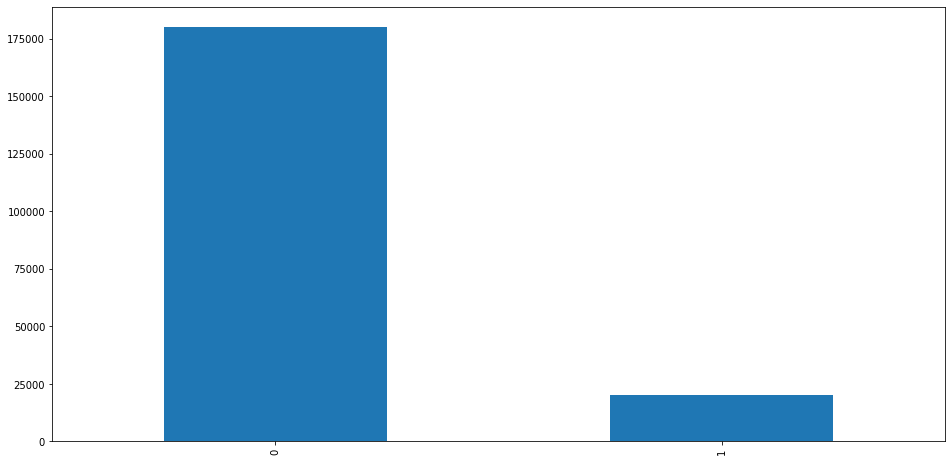

In [7]:
recuento_target(train)

Se van a generar dos dataset mas de datos, uno igualando el número de targets 0 a los 1 y otro al contrario.

In [8]:
train_under = over_sampling(train)
train_over = under_sampling(train)

El porcentaje de 0 en el target es: 50.0 %
El porcentaje de 1 en el target es: 50.0 %


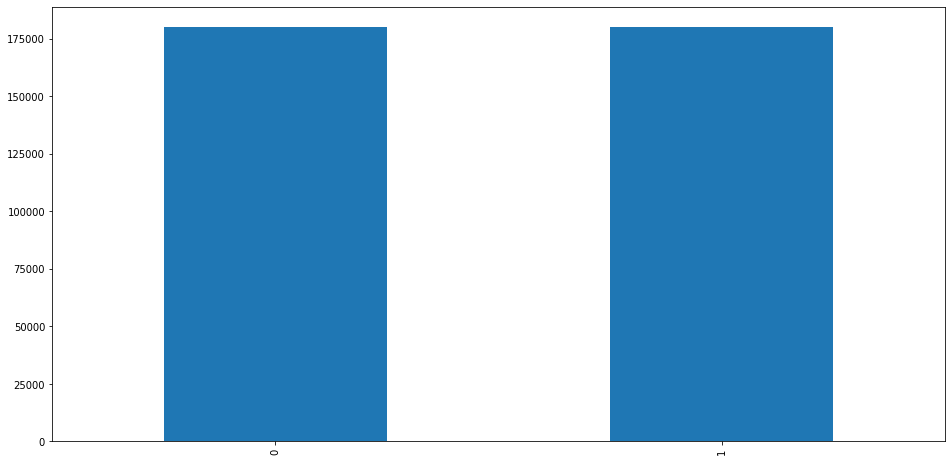

In [9]:
recuento_target(train_under)

Ahora ya están los datos balanceados. Se han generado dos dataframes, uno donde se ha hecho over sampler: 'train_over' y otro donde se ha hecho under sampler: 'train_under'

## Comparción de modelos con dataframe undersampleado y oversampleado

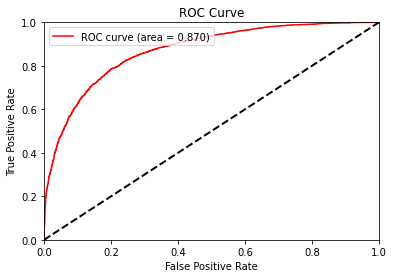

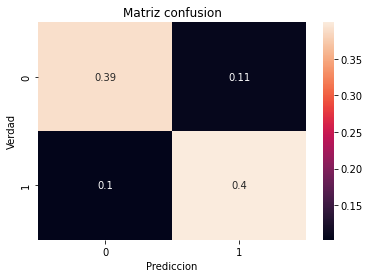

------------------


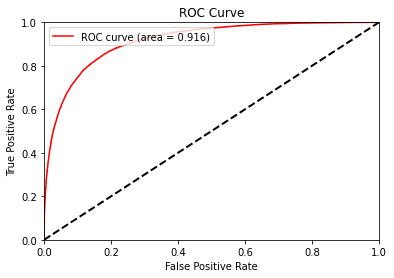

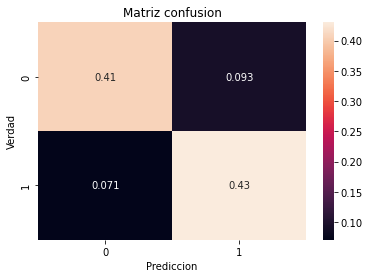

------------------


In [10]:
for e in [train_over, train_under]:
    # Separación en parte de train y test
    X_train, X_test, y_train, y_test = train_test(e)

    # print("Datos:", e)

    # Entrenamiento del modelo
    fpr, tpr, roc_auc, y_pred = reg_model(LGBMClassifier(n_jobs=-1), X_train, X_test, y_train, y_test)

    # Plot de la curva roc y de la matriz de confusión
    roc_curve_plot(fpr, tpr, roc_auc)
    confusion_matrix_total(y_test, y_pred)
    print('------------------')


### Conclusiones

Se comprueba que se ha mejorado el desempeño del modelo con el balanceo de datos, dando mejores datos el array al que se le ha aplicado el under sampling

## Modelos

In [11]:
# Función para obtener la mejor conbinación de parámetros posible para el modelo

def objetivo(params):
    '''
    This function searches for the best possible combination of 
    parameters for the model

    Parameters:
    params (dict): Dictionary with the posible params and its ranges
    '''

    modelo=LGBMClassifier(num_leaves=int(params['num_leaves']),
                max_depth=int(params['max_depth']),
                learning_rate=params['learning_rate'],
                n_estimators=int(params['n_estimators']),
                subsample=params['subsample'],
                min_child_weight=params['min_child_weight'],
                reg_lambda=params['reg_lambda'])
                    
    eval_set=[(X_train, y_train), (X_test, y_test)]
    
    modelo.fit(X_train, y_train,
                eval_set=eval_set,
                eval_metric='auc',
                verbose=False)
    
    y_pred=modelo.predict(X_test)
    
    rmse=mse(y_test, y_pred, squared=False)
    
    return {'loss': rmse, 'status': STATUS_OK}

### Under sampling

In [12]:
X_train, X_test, y_train, y_test = train_test(train_under)

best=fmin(fn=objetivo,
            space=params,
            algo=tpe.suggest,
            max_evals=25,
            trials=Trials())

best

  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

/home/rodrigo/miniconda3/envs/proyectofinal/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



In [ ]:
lgbm =LGBMClassifier(num_leaves=int(best['num_leaves']),
        max_depth=int(best['max_depth']),
        learning_rate=best['learning_rate'],
        n_estimators=int(best['n_estimators']),
        subsample=best['subsample'],
        min_child_weight=best['min_child_weight'],
        reg_lambda=best['reg_lambda'])

lgbm = lgbm.fit(X_train, y_train, eval_metric='auc', eval_set=(X_test , y_test), verbose=30, early_stopping_rounds= 50)

In [ ]:
fpr, tpr, _ = roc_curve(y_test, lgbm.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)
roc_curve_plot(fpr, tpr, roc_auc)

confusion_matrix_total(y_test, lgbm.predict(X_test))

In [ ]:
ax=sns.heatmap(confusion_matrix(y_test, lgbm.predict(X_test))/sum(sum(confusion_matrix(y_test, lgbm.predict(X_test)))), annot=True)

plt.title('Matriz confusion')
plt.ylabel('Verdad')
plt.xlabel('Prediccion')
plt.show();

In [ ]:
print( 'Train roc auc score for LGBM en el train: ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:, 1]))
print( 'Test roc auc score for LGBM en el test: ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:, 1]))

In [ ]:

fpr, tpr, _ = roc_curve(y_test, lgbm.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='red', label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="upper left")
plt.show()

In [ ]:
# Predicción del modelo

sample = pd.read_csv('/media/rodrigo/Rodrigo/sample_submission.csv')

test =  pd.read_csv('/media/rodrigo/Rodrigo/test_modified.csv')

sample.target=lgbm.predict(test)

sample.to_csv('/media/rodrigo/Rodrigo/sample_submission.csv', index=False)